# kMeans and Clustering

What is a cluster?  

A cluster is a collection of data points aggregated together because of certain similarities. We group points together based on their features' similarity. These groups can then be classified in a certain way, or used for other purposes.  

Simply put, here are clusters of data points:  
![Image showing 2D points and clusters traced around them](https://bookdown.org/tpinto_home/Unsupervised-learning/kmeans.png)  
Credit: [Bookdown](https://bookdown.org/tpinto_home/Unsupervised-learning/k-means-clustering.html)  

As we can see, the colored areas traced around points devine groups of points. These are the clusters.

# kMeans

This is one of the most popular algorithms in ML. It is used for clustering data points.  
The idea is simple. We have a dataset of points, and we want to group them into clusters. We define how many such clusters should exist (a hyper-parameter). We then (often randomly, but we'll discuss it later) initialize centroids that represent the center of each cluster.  
We calculate the distance (again, we'll discuss it later) between each point and each centroid. We then assign each point to the cluster of the closest centroid.  
The last step is to update the centroids. Based on each point assigned to each cluster, we calculate a new position for each centroid by taking the mean of all points assigned to it.  

And that's it! We repeatedly calculate distances between points and centroids and update the centroids' positions, until we reach a stopping criterion.

Let us now implement this algorithm to see it in action, and then we'll discuss more details regarding initialization, optimization, and distance calculation.

In [1]:
# Import libraries for kMeans
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
# Library to generate blobs of data
from sklearn.datasets import make_blobs

In [2]:
# Generate data
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, random_state=0, cluster_std=0.5)

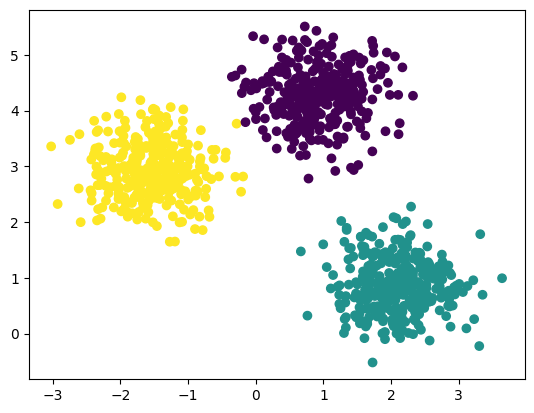

In [3]:
# Visualize
plt.scatter(X[:,0], X[:,1], c=y)

We have visualized them knowing the assigned clusters in order to get a better understanding of the layout of our data. The algorithm itself does not know this information.

In [4]:
# Use sklearn to cluster data
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# Get the labels
y_pred = kmeans.labels_
# Get the centroids
centroids = kmeans.cluster_centers_


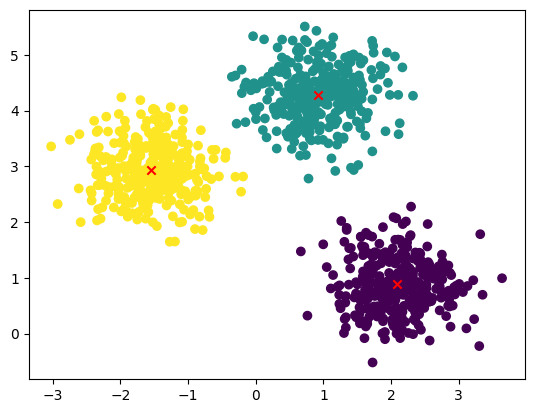

In [5]:
# Visualize clusters using labels
plt.scatter(X[:,0], X[:,1], c=y_pred)
# Visualize centroids
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x')

As we can see, sklearn managed to find the centroids (red x's) and group the points into clusters. Let's now implement the algorithm ourselves.

In [6]:
# Our own implementation of kMeans
def kMeans(X, k, maxIters = 10, plot_progress = None):
    # Number of data points
    m = X.shape[0]
    # Number of features
    n = X.shape[1]
    # Initialize centroids randomly
    centroids = X[np.random.choice(m, k, replace=False), :]
    # Initialize labels
    labels = np.zeros(m)
    # Initialize distances
    distances = np.zeros((m, k))
    # Initialize history of centroids
    history_centroids = centroids
    # Initialize history of labels
    history_labels = labels
    # Initialize history of distances
    history_distances = distances
    # Initialize counter
    itersFinal = 0
    # Iterate until convergence or maxIters
    for iters in range(maxIters):
        # Compute distances
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - centroids[i,:], axis=1)
        # Assign labels
        labels = np.argmin(distances, axis=1)
        # Update history
        history_centroids = np.vstack((history_centroids, centroids))
        history_labels = np.vstack((history_labels, labels))
        history_distances = np.vstack((history_distances, distances))
        # Update centroids
        for i in range(k):
            centroids[i,:] = np.mean(X[labels == i, :], axis=0)
        # Check for convergence
        itersFinal = iters
        if iters > 0:
            if np.array_equal(history_labels[-1,:], history_labels[-2,:]):
                break
    # If plot_progress flag is true, plot the progress
    if plot_progress is not None:
        # Plot figure with iteration windows
        fig, ax = plt.subplots(nrows=iters, ncols=1, figsize=(15,15))
        for iteration in range(itersFinal):
            # Plot data
            ax[iteration].scatter(X[:,0], X[:,1], c=history_labels[iteration])
            # Plot centroids
            ax[iteration].scatter(history_centroids[iteration*k:(iteration+1)*k,0], history_centroids[iteration*k:(iteration+1)*k,1], c='red', marker='x')
            # Set title
            ax[iteration].set_title('Iteration {}'.format(iteration+1))
    # Return history
    return history_centroids, history_labels, history_distances

In [12]:
# Use our own algorithm to cluster data
history_centroids, history_labels, history_distances = kMeans(X, 3, maxIters=3)


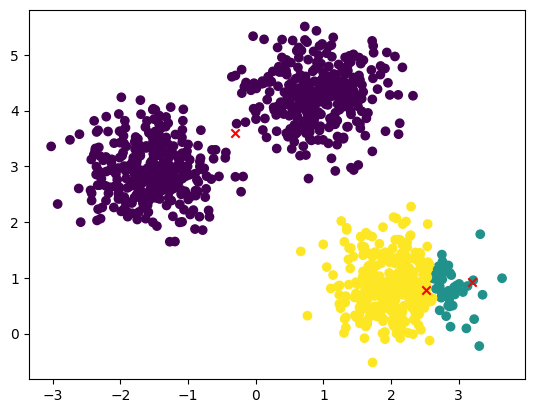

In [13]:
# Visualize clusters using labels
plt.scatter(X[:,0], X[:,1], c=history_labels[-1,:])
# Visualize centroids
plt.scatter(history_centroids[-4:-1, 0], history_centroids[-4:-1,1], c='red', marker='x')

Ah, here it is! Why do we not get the same results?  (Note: any kind of factor that is based on randomness does influence results; in my case, with 10 iterations I did not get a great convergence at first, but with 100 iterations I did. Upon subsequent runs, the algorithm managed to get good results with 10 iterations as well, so I changed maxIter to 3 to make sure you see this problem in action. This is due to the random.choice function; it does not have a seed we can set to get the same results every time, unfortunately)

### Local minimum & Convergence

As we can see from the algorithm, we have the hyper-parameter of the number of iterations. As we've seen before with gradient descent, choosing a low number of iterations can lead to subpar results. Let's do the same with 10x more iterations.

In [9]:
# Apply our kMeans 100 iterations
history_centroids, history_labels, history_distances = kMeans(X, 3, maxIters=100)


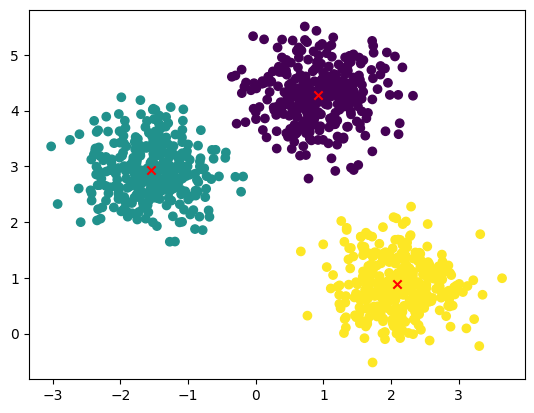

In [10]:
# Visualzie
plt.scatter(X[:,0], X[:,1], c=history_labels[-1,:])
# Visualize centroids
plt.scatter(history_centroids[-4:-1, 0], history_centroids[-4:-1,1], c='red', marker='x')

Here we go! Now we get the same results as sklearn. Of course, 100 iterations might be overkill, but we've proven our point.  

### Beware

There are certain cases where the algorithm might not converge. This is because of the initialization of the centroids. Let's now go over the algorithm and explain it in more detail.  

We have a few parameters: the dataset, number of clusters, number of iterations, and a flag to plot the progress (each step of the way).
```
def kMeans(X, k, maxIters = 10, plot_progress = None):
```
The next step is the initialization phase. Where possible, we initialize with a lot of 0's. It is at this stage that we bump into the first decision: centroid initialization. Here we choose to initialize the centroids randomly. This choice might lead to a "wrong" convergence, as we've mentioned above. Another common choice is to initialize the centroid with random points from the dataset, or just choose the first k points from the dataset. These are far better options that save us from the local minimum problem.  
It is also here that we initialize our distances matrix. The choice of initialization is uninteresting, since we just initialize it with 0's, but the choice of distance calculation is very important.  
##### Distance
We've already discussed distances in the context of [kNN](../supervisedLearning/kNearestNeighbors.ipynb). We've seen that the most common distance is the Euclidean distance. This is the distance we'll use here as well. Keep in mind that the other options are valid as well, depending on our data space.
```
    # Number of data points
    m = X.shape[0]
    # Number of features
    n = X.shape[1]
    # Initialize centroids randomly
    centroids = X[np.random.choice(m, k, replace=False), :]
    # Initialize labels
    labels = np.zeros(m)
    # Initialize distances
    distances = np.zeros((m, k))
    # Initialize history of centroids
    history_centroids = centroids
    # Initialize history of labels
    history_labels = labels
    # Initialize history of distances
    history_distances = distances
    # Initialize counter
    iters = 0
```
We start iterating for the number of iterations we've chosen as a hyper-parameter.
```
    # Iterate until convergence or maxIters
    for iters in range(maxIters):
```
We compute the distances between each point and each centroid. We then assign each point to the cluster of the closest centroid.
```
        # Compute distances
        for i in range(k):
            distances[:,i] = np.linalg.norm(X - centroids[i,:], axis=1)
        # Assign labels
        labels = np.argmin(distances, axis=1)
```
As part of our "track progress" flag, we memorize the centroids, labels, and distances at each iteration. We can use these to plot our progress, or check for other stopping criteria (will discuss in a moment).
```
        # Update history
        history_centroids = np.vstack((history_centroids, centroids))
        history_labels = np.vstack((history_labels, labels))
        history_distances = np.vstack((history_distances, distances))
```
The last step as part of each iteration is to update the centroids' positions. We simply use the mean of all points assigned to each cluster. Other options exist, but this is the most common and I have not seen a reason to use anything else. Of course, you can (if you wish) be creative about it.
```
        # Update centroids
        for i in range(k):
            centroids[i,:] = np.mean(X[labels == i, :], axis=0)
```
##### Convergence criteria
Our main stopping criteria is the number of iterations. We can also choose to stop when the centroid move less than a certain threshold (or don't move at all). These are both valid points, but you must always consider the trade-off between speed and accuracy, plus the possibility of getting stuck in a local minimum.
```
        # Check for convergence
        if iters > 0:
            if np.array_equal(history_labels[-1,:], history_labels[-2,:]):
                break
```
We return the history of centroids, labels, and distances. The last row of each is the final result.
```
    # Return history
    return history_centroids, history_labels, history_distances
```

Let's see how the centroids progress with each iteration.

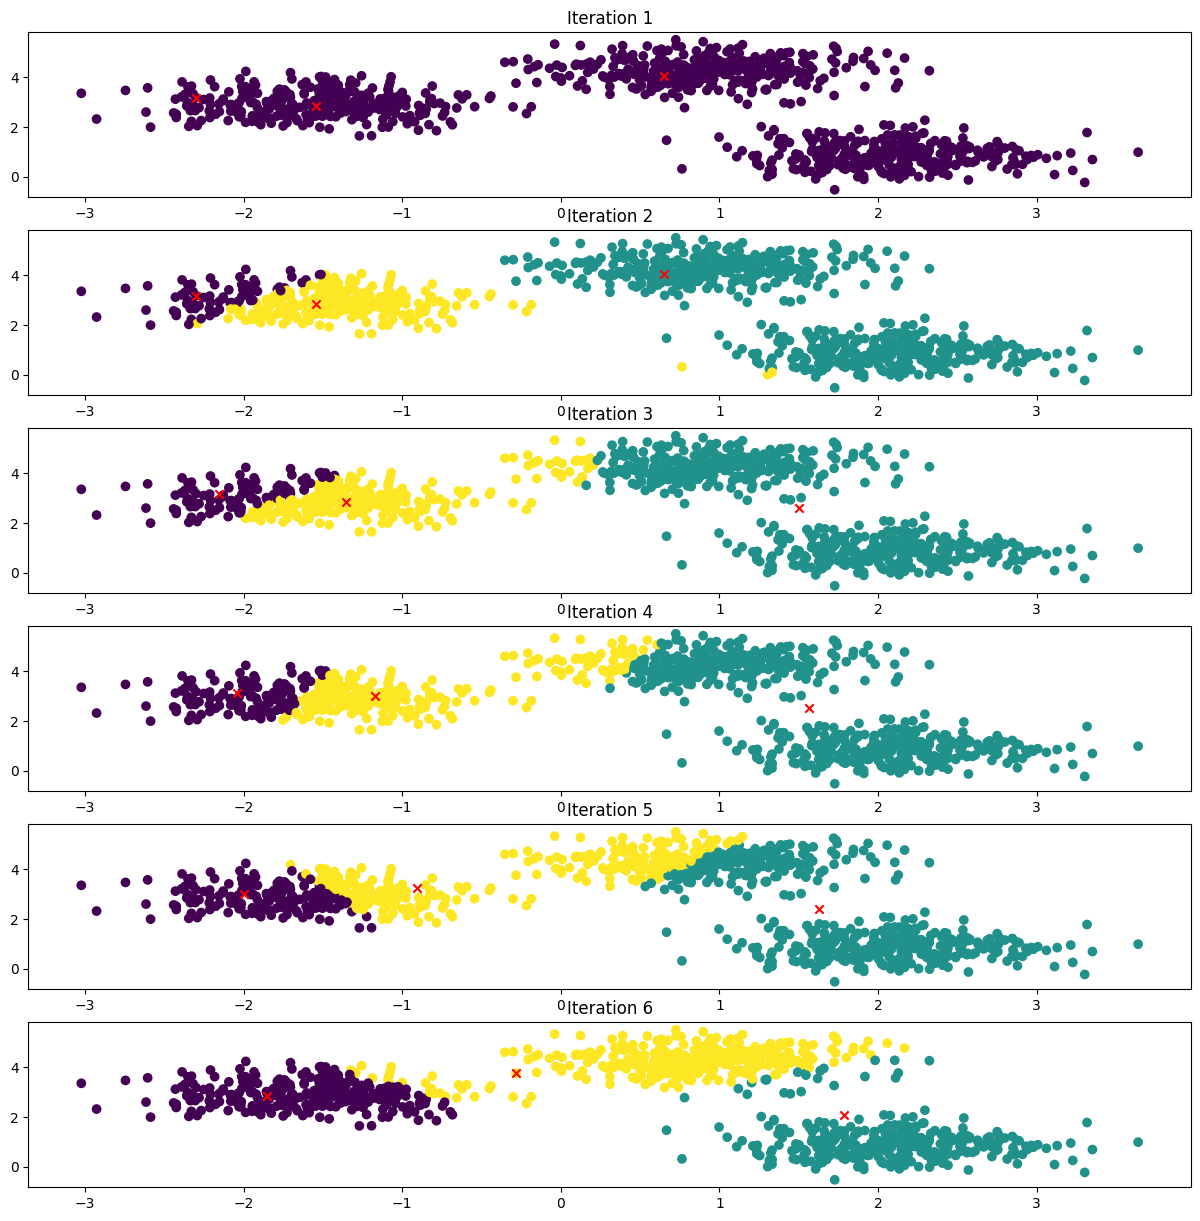

In [11]:
# Algorithm convergence progress
history_centroids, history_labels, history_distances = kMeans(X, 3, maxIters=10, plot_progress=True)


Remember that we our stopping criteria involves checking if the centroids don't move, so we might get less iterations than we've asked for. In this case, I got 4. Future runs might be different.  

After subsequent runs, I got the unlucky local minimum convergence. This is what it looks like:
![kMeans convergence](../assets/kMeansLocMin.png)

In order to get past this problem, the best we can do is run the algorithm multiple times and save our best result (meaning centroids' positions).

# Looking back

This is the end of our kMeans discussion. It's quite a simple algorithm, but really powerful. It is often used as a starting point for the problems we encounter, since it is so easy to implement and understand. One of the best things about kMeans is that it can run multiple instances in parallel. On top of that, it doesn't assume anything about the data (not biased).  

The downside is that it is sensitive to initialization decisions, it is not guaranteed to converge (which is why we run multiple times), and it is sensitive to outliers (although we can minimize this effect through different distance functions & other practices, including data cleaning).

Up next
[Dimensionality Reduction](../unsupervisedLearning/dimensionalityReduction.ipynb)
